# Agent Metrics Analysis - Experiment 2

This notebook processes and visualizes eval metrics between different haptic weights to investigate if touch can be better utilised if more pronounced in the system

In [1]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
import os
import numpy as np
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [2]:
from __future__ import annotations

import glob
import os
import time
import csv

import supersuit as ss
from stable_baselines3 import PPO
from sb3_contrib import RecurrentPPO
from scipy import stats as sci_stats

import gymnasium as gym 

from pettingzoo.sisl import waterworld_v4, waterworld_model1

import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.evaluation import evaluate_policy
from pettingzoo.utils.conversions import aec_to_parallel
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement, CheckpointCallback

import numpy as np 
import pandas as pd

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor


## Set the log directory and process the data

In [3]:
# Set your log directory here
env_fn = waterworld_model1
env_kwargs = {"n_pursuers" : 2, "haptic_modulation_type" : 'average'}


# Evaluate a trained agent vs a random agent
env = env_fn.env(render_mode=None, **env_kwargs)
log_dir_08 = "/Users/idil/PettingZoo/SB3-training/logs/myriad-average_pettingzoo.sisl.waterworld_model1_20240831-230421/"
latest_policy_08 = "/Users/idil/PettingZoo/SB3-training/logs/myriad-average_pettingzoo.sisl.waterworld_model1_20240831-230421/best_model.zip"

log_dir_03 = "/Users/idil/PettingZoo/SB3-training/logs/myriad-average_pettingzoo.sisl.waterworld_model1_20240902-143315/"
latest_policy_03 = "/Users/idil/PettingZoo/SB3-training/logs/myriad-average_pettingzoo.sisl.waterworld_model1_20240902-143315/best_model.zip"

log_dir_05 = "/Users/idil/PettingZoo/SB3-training/logs/myriad-average_pettingzoo.sisl.waterworld_model1_20240830-113028/"
latest_policy_05 = "/Users/idil/PettingZoo/SB3-training/logs/myriad-average_pettingzoo.sisl.waterworld_model1_20240830-113028/best_model.zip"

model_08 = RecurrentPPO.load(latest_policy_08)
model_03 = RecurrentPPO.load(latest_policy_03)
model_05 = RecurrentPPO.load(latest_policy_05)




/Users/idil/anaconda3/envs/pettingzoo-sb3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
obs = env.reset()

    # Cell and hidden state of the LSTM
lstm_states = None
num_envs = 1
    # Episode start signals are used to reset the lstm states
episode_starts = np.ones((num_envs,), dtype=bool)
num_games = 10 

In [8]:
def evaluate_model(model, env, num_games=20, seed_start=1000):
    all_data = []
    for game in range(num_games):
        env.reset(seed=seed_start + game)
        game_data = {agent: {
            'rewards': [], 'arousal': [], 'satiety': [], 
            'social-touch': [], 'social-touch-modulation': [],
            'evader-eaten': [], 'food_indicator': [],
            'nutrition-per-pursuer': [], 'poison_indicator': [],
            'step': []
        } for agent in env.possible_agents}
        
        step = 0
        for agent in env.agent_iter():
            obs, reward, termination, truncation, info = env.last()
            
            for a in env.agents:
                game_data[a]['rewards'].append(env.rewards[a])
                game_data[a]['step'].append(step)
                
                for metric in ['arousal', 'satiety', 'social-touch', 'social-touch-modulation',
                               'evader-eaten', 'food_indicator', 'nutrition-per-pursuer', 'poison_indicator']:
                    if metric in info:
                        parts = info[metric].split('_')
                        agent_name = f"{parts[0]}_{parts[1]}"
                        value = parse_metric_value(parts[2])
                        game_data[agent_name][metric].append(value)
                    else:
                        game_data[a][metric].append(None)
            
            if termination or truncation:
                break
            else:
                act = model.predict(obs, deterministic=True)[0]
            env.step(act)
            step += 1
        
        for agent, data in game_data.items():
            df = pd.DataFrame(data)
            df['agent'] = agent
            df['game'] = game
            all_data.append(df)
    
    return pd.concat(all_data, ignore_index=True)

def parse_metric_value(value):
    if value == "initial":
        return 0
    elif value in ["True", "False"]:
        return 1 if value == "True" else 0
    else:
        try:
            return float(value)
        except ValueError:
            print(f"Warning: Unexpected value '{value}'. Setting to None.")
            return None

def calculate_cumulative_rewards(df):
    df['cumulative_rewards'] = df.groupby(['game', 'agent'])['rewards'].cumsum()
    return df

def compare_models(models, env, num_games=20, seed_start=1000):
    all_model_data = []
    for i, model in enumerate(models, 1):
        df = evaluate_model(model, env, num_games, seed_start)
        df['model'] = f'Model {i}'
        all_model_data.append(df)
    
    combined_df = pd.concat(all_model_data, ignore_index=True)
    combined_df = calculate_cumulative_rewards(combined_df)
    return combined_df

def plot_metric_comparison(df, metric, num_games=10):
    plt.figure(figsize=(12, 6))
    for model in df['model'].unique():
        model_data = df[(df['model'] == model) & (df['game'] < num_games)]
        mean_values = model_data.groupby('step')[metric].mean()
        std_error = model_data.groupby('step')[metric].sem()
        plt.plot(mean_values.index, mean_values.values, label=model)
        plt.fill_between(mean_values.index,
                         mean_values.values - 1.96*std_error.values,
                         mean_values.values + 1.96*std_error.values,
                         alpha=0.2)
    plt.title(f'{metric.capitalize()} Comparison')
    plt.xlabel('Step')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

def analyze_social_touch(df):
    touch_freq = df.groupby(['model', 'game'])['social-touch'].apply(lambda x: (x > 0).mean()).reset_index()
    touch_mod = df.groupby(['model', 'game'])['social-touch-modulation'].mean().reset_index()
    
    print("Social Touch Frequency Statistics:")
    print(touch_freq.groupby('model')['social-touch'].describe())
    print("\nSocial Touch Modulation Statistics:")
    print(touch_mod.groupby('model')['social-touch-modulation'].describe())
    
    # ANOVA for touch frequency
    f_stat, p_val = sci_stats.f_oneway(*[group['social-touch'].values for name, group in touch_freq.groupby('model')])
    print("\nANOVA for Social Touch Frequency:")
    print(f"F-statistic: {f_stat}, p-value: {p_val}")
    
    # ANOVA for touch modulation
    f_stat, p_val = sci_stats.f_oneway(*[group['social-touch-modulation'].values for name, group in touch_mod.groupby('model')])
    print("\nANOVA for Social Touch Modulation:")
    print(f"F-statistic: {f_stat}, p-value: {p_val}")
    
    # Tukey's test for pairwise comparisons
    tukey_freq = pairwise_tukeyhsd(touch_freq['social-touch'], touch_freq['model'])
    tukey_mod = pairwise_tukeyhsd(touch_mod['social-touch-modulation'], touch_mod['model'])
    
    print("\nTukey's Test for Social Touch Frequency:")
    print(tukey_freq)
    print("\nTukey's Test for Social Touch Modulation:")
    print(tukey_mod)

def analyze_rewards(df):
    final_rewards = df.groupby(['model', 'game'])['cumulative_rewards'].last().reset_index()
    
    print("Cumulative Rewards Statistics:")
    print(final_rewards.groupby('model')['cumulative_rewards'].describe())
    
    # ANOVA for cumulative rewards
    f_stat, p_val = sci_stats.f_oneway(*[group['cumulative_rewards'].values for name, group in final_rewards.groupby('model')])
    print("\nANOVA for Cumulative Rewards:")
    print(f"F-statistic: {f_stat}, p-value: {p_val}")
    
    # Tukey's test for pairwise comparisons
    tukey = pairwise_tukeyhsd(final_rewards['cumulative_rewards'], final_rewards['model'])
    print("\nTukey's Test for Cumulative Rewards:")
    print(tukey)

def main_analysis(models, env, num_games=20, seed_start=1000):
    combined_df = compare_models(models, env, num_games, seed_start)
    
    # Plotting
    plot_metric_comparison(combined_df, 'cumulative_rewards')
    plot_metric_comparison(combined_df, 'social-touch')
    plot_metric_comparison(combined_df, 'social-touch-modulation')
    
    # Analysis
    analyze_social_touch(combined_df)
    analyze_rewards(combined_df)

# Usage
# models = [model1, model2, model3]
# env = your_environment
# main_analysis(models, env)

In [22]:
models = [model_08, model_05, model_03]


In [10]:
combined_df = compare_models(models, env, num_games, 11345)
#seed for normal comparison: 11345

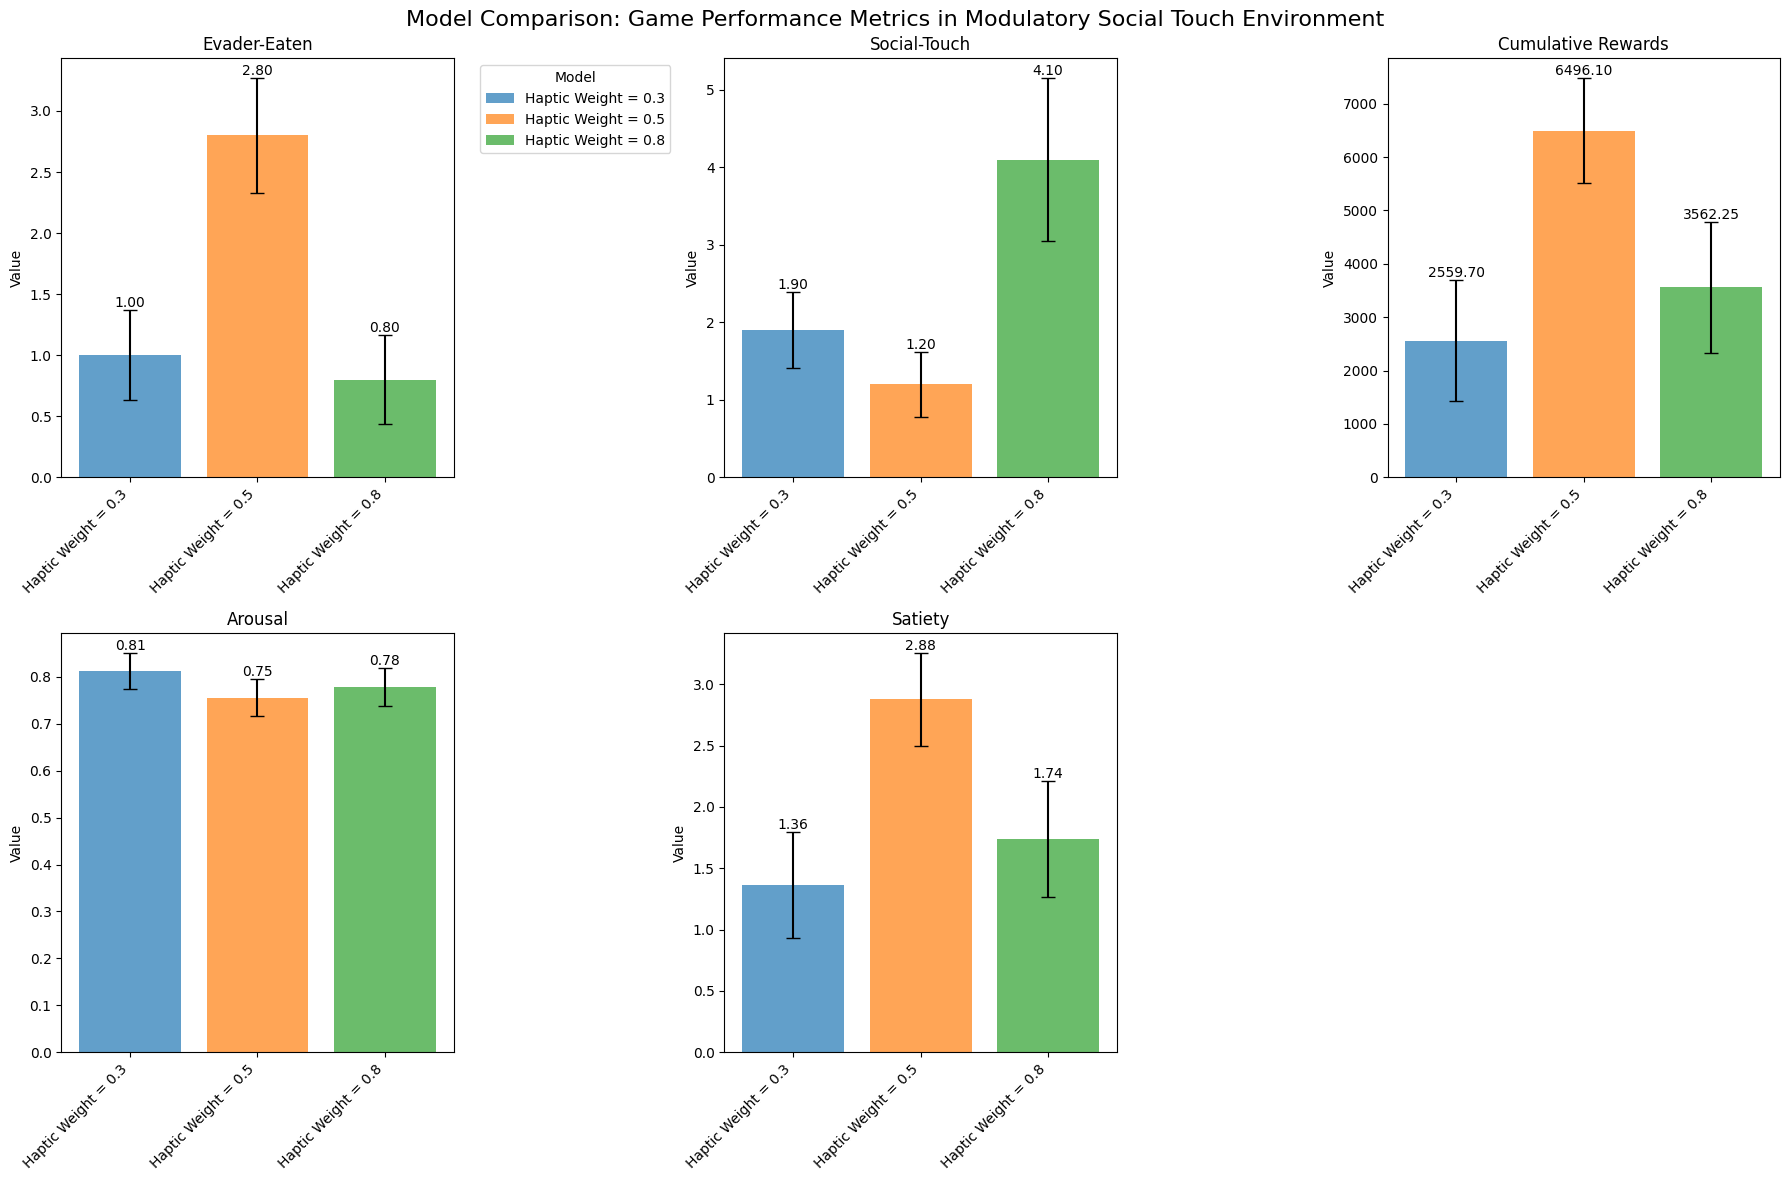

In [20]:

def prepare_data_for_plotting(df):
    # Calculate cumulative rewards for each game
    df['cumulative_rewards'] = df.groupby(['model', 'game', 'agent'])['rewards'].cumsum()
    
    # Get the final values for each game
    final_values = df.groupby(['model', 'game', 'agent']).agg({
        'cumulative_rewards': 'last',
        'evader-eaten': 'sum',
        'social-touch': 'sum',
        'arousal': 'mean',  # Taking mean arousal for the game
        'satiety': 'mean'   # Taking mean satiety for the game
    }).reset_index()

    # Map model names to haptic weight values
    model_map = {
        'Model 1': 'Haptic Weight = 0.8',
        'Model 2': 'Haptic Weight = 0.5',
        'Model 3': 'Haptic Weight = 0.3'
    }
    final_values['model'] = final_values['model'].map(model_map)
    
    return final_values

def plot_model_comparisons(df, title):
    # Prepare data
    plot_data = prepare_data_for_plotting(df)
    
    # List of metrics to plot
    metrics = ['evader-eaten', 'social-touch', 'cumulative_rewards', 'arousal', 'satiety']
    
    # Set up the plot
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(title, fontsize=16)
    
    # Define colors for each model
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # You can change these colors as needed
    
    for i, metric in enumerate(metrics):
        ax = axes[i // 3, i % 3]
        
        # Calculate mean and standard error for each model
        model_stats = plot_data.groupby('model')[metric].agg(['mean', 'sem']).reset_index()
        
        # Plot mean with error bars
        for j, model in enumerate(model_stats['model']):
            mean = model_stats.loc[j, 'mean']
            sem = model_stats.loc[j, 'sem']
            ax.bar(j, mean, yerr=sem, capsize=5, color=colors[j], alpha=0.7, label=model)
        
        # Customize the plot
        ax.set_title(f'{metric.replace("_", " ").title()}')
        ax.set_ylabel('Value')
        ax.set_xticks(range(len(model_stats)))
        ax.set_xticklabels(model_stats['model'], rotation=45, ha='right')
        
        # Add value labels on top of each bar
        for j, v in enumerate(model_stats['mean']):
            ax.text(j, v + model_stats.loc[j, 'sem'], f'{v:.2f}', 
                    ha='center', va='bottom')
        
        # Add legend to the first subplot only
        if i == 0:
            ax.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Remove the empty subplot
    fig.delaxes(axes[1, 2])
    
    plt.tight_layout()
    #plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
# combined_df = pd.concat([df1, df2, df3], ignore_index=True)
plot_model_comparisons(combined_df, 'Model Comparison: Game Performance Metrics in Modulatory Social Touch Environment')

Compare in environment where there is no social touch 

In [15]:
# Set your log directory here
env_fn = waterworld_model1
env_kwargs = {"n_pursuers" : 2, "haptic_modulation_type" : 'no_effect'}


# Evaluate a trained agent vs a random agent
env = env_fn.env(render_mode=None, **env_kwargs)

obs = env.reset()

    # Cell and hidden state of the LSTM
lstm_states = None
num_envs = 1
    # Episode start signals are used to reset the lstm states
episode_starts = np.ones((num_envs,), dtype=bool)
num_games = 10 

combined_no_touch_df = compare_models(models, env, num_games, 1987)

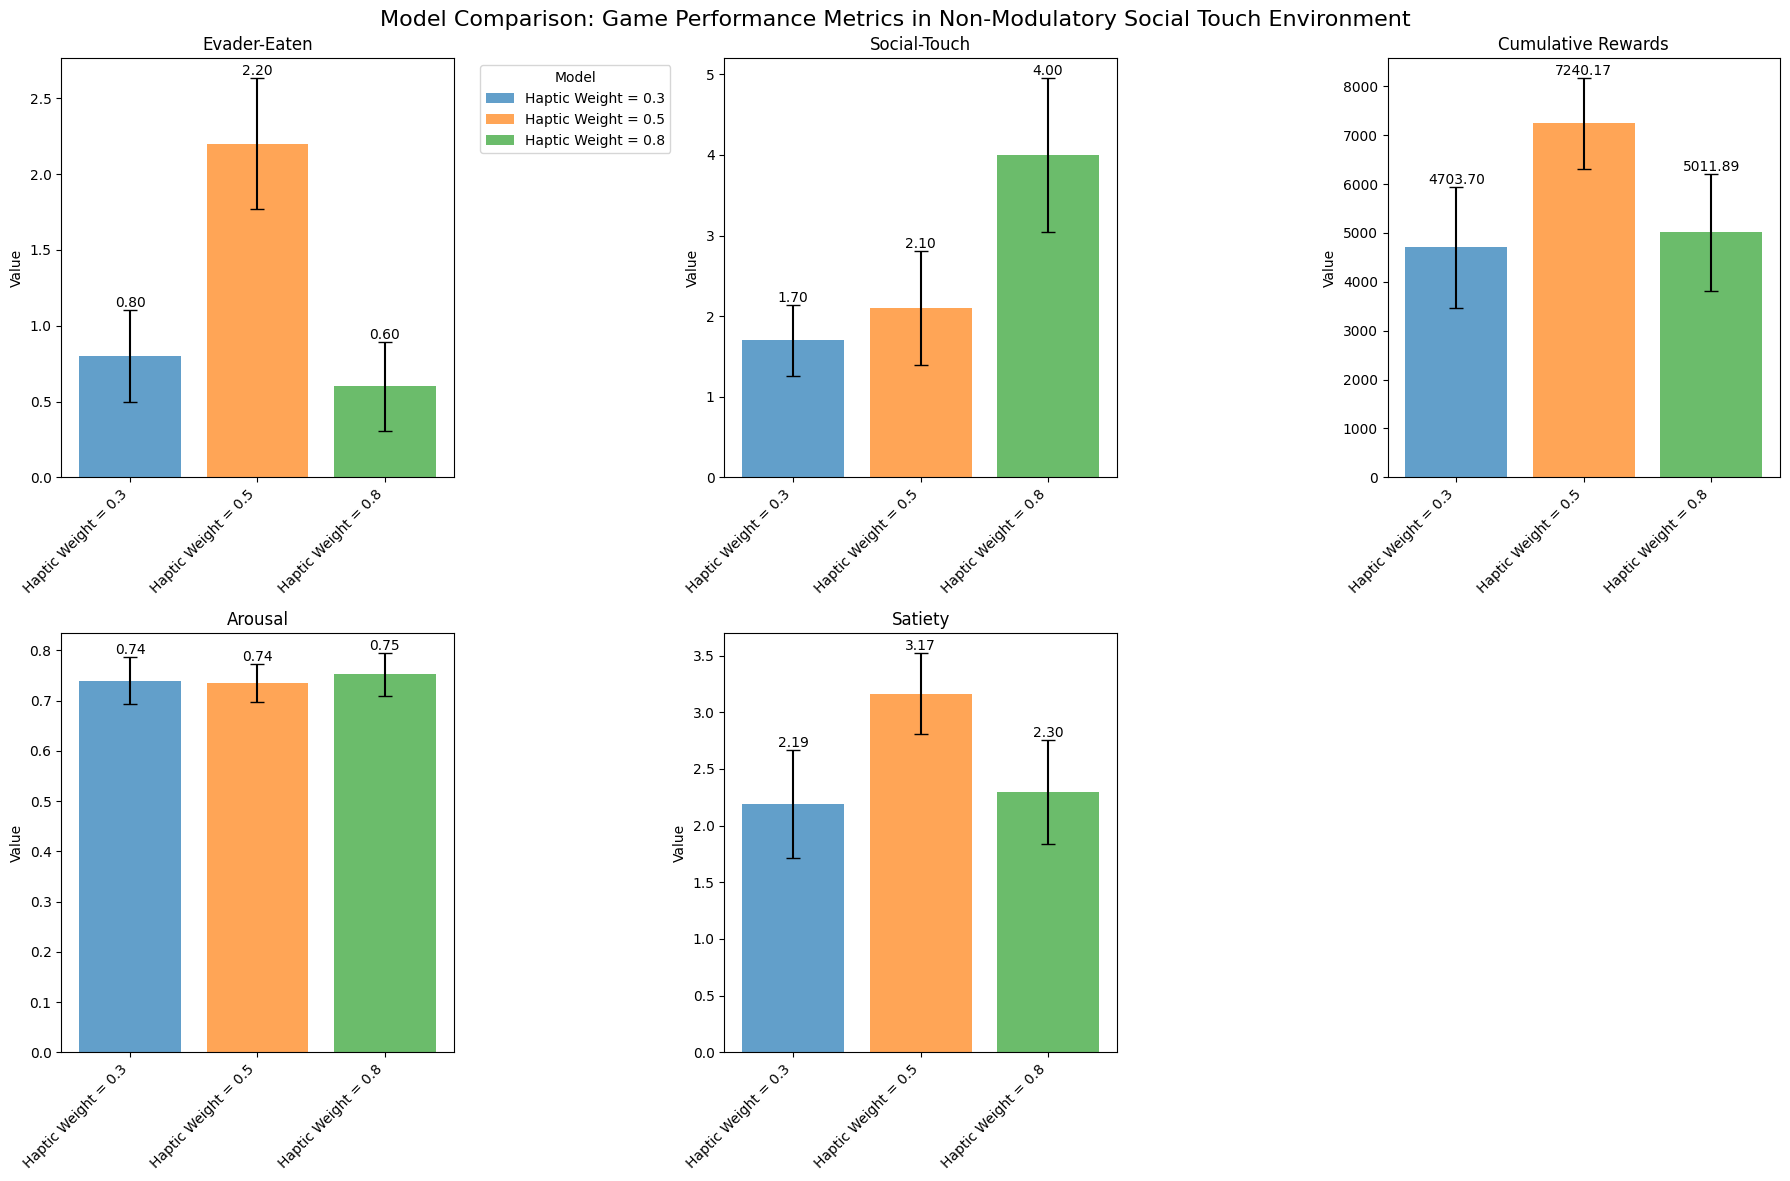

In [21]:
plot_model_comparisons(combined_no_touch_df, 'Model Comparison: Game Performance Metrics in Non-Modulatory Social Touch Environment')